# Nltk reuters news groups text - Multiclass classification

Cf: https://www.johnwittenauer.net/language-exploration-using-vector-space-models/

In [1]:
import gensim
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


In [2]:
from nltk.corpus import reuters

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
vocabulary = set(reuters.words())

In [5]:
fdist = nltk.FreqDist(reuters.words())
fdist.most_common(30)

[('.', 94687),
 (',', 72360),
 ('the', 58251),
 ('of', 35979),
 ('to', 34035),
 ('in', 26478),
 ('said', 25224),
 ('and', 25043),
 ('a', 23492),
 ('mln', 18037),
 ('vs', 14120),
 ('-', 13705),
 ('for', 12785),
 ('dlrs', 11730),
 ("'", 11272),
 ('The', 10968),
 ('000', 10277),
 ('1', 9977),
 ('s', 9298),
 ('pct', 9093),
 ('it', 8842),
 (';', 8762),
 ('&', 8698),
 ('lt', 8694),
 ('on', 8556),
 ('from', 7986),
 ('cts', 7953),
 ('is', 7580),
 ('>', 7449),
 ('that', 7377)]

In [70]:
# Cleaning from the stop words
stopwords = nltk.corpus.stopwords.words('english')
cleansed_words = [w.lower() for w in reuters.words() if w.isalpha() and w.lower() not in stopwords]
vocabulary = set(cleansed_words)
len(vocabulary)

29027

In [71]:
fdist = nltk.FreqDist(cleansed_words)
fdist.most_common(30)

[('said', 25383),
 ('mln', 18623),
 ('vs', 14341),
 ('dlrs', 12417),
 ('pct', 9810),
 ('lt', 8696),
 ('cts', 8361),
 ('year', 7529),
 ('net', 6989),
 ('u', 6392),
 ('billion', 5829),
 ('loss', 5124),
 ('would', 4673),
 ('company', 4670),
 ('shr', 4182),
 ('inc', 4121),
 ('bank', 3654),
 ('corp', 3399),
 ('oil', 3272),
 ('last', 3243),
 ('share', 3160),
 ('trade', 3098),
 ('one', 2963),
 ('profit', 2960),
 ('market', 2811),
 ('new', 2716),
 ('qtr', 2674),
 ('two', 2665),
 ('shares', 2652),
 ('stock', 2629)]

### Load Data and Vectorization

In [8]:
reuters.words(categories='barley')

['FRENCH', 'FREE', 'MARKET', 'CEREAL', 'EXPORT', ...]

**Note**: for test set use transform, for train set use fit_transform

In [78]:
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    vectorizer = TfidfVectorizer(stop_words=stopwords, tokenizer=tokenizer.tokenize,lowercase=True )
    mlb = MultiLabelBinarizer()

    documents = reuters.fileids()
    test = [d for d in documents if d.startswith('test/')]
    train = [d for d in documents if d.startswith('training/')]

    docs = {}
    raw_train = [reuters.raw(doc_id) for doc_id in train]
    raw_test = [reuters.raw(doc_id) for doc_id in test]
    
    X_train = vectorizer.fit_transform(raw_train).toarray()
    X_test = vectorizer.transform(raw_test).toarray()
    
    y_train = mlb.fit_transform([reuters.categories(doc_id)
                                     for doc_id in train])
    y_test = mlb.transform([reuters.categories(doc_id)
                                for doc_id in test])


In [79]:
print("X_train: ",X_train.shape, "y_train:" ,y_train.shape,"\n")
print("X_test: ",X_test.shape, "y_test:" , y_test.shape)

X_train:  (7769, 24573) y_train: (7769, 90) 

X_test:  (3019, 24573) y_test: (3019, 90)


### SVC

In [80]:
# Build model
clf = OneVsRestClassifier(LinearSVC(random_state=42))
clf.fit(X_train, y_train)
 
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       719
           1       1.00      0.43      0.61        23
           2       1.00      0.64      0.78        14
           3       0.95      0.63      0.76        30
           4       0.89      0.44      0.59        18
           5       0.00      0.00      0.00         1
           6       1.00      0.94      0.97        18
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         3
           9       0.96      0.96      0.96        28
          10       1.00      0.78      0.88        18
          11       0.00      0.00      0.00         1
          12       0.96      0.77      0.85        56
          13       1.00      0.55      0.71        20
          14       0.00      0.00      0.00         2
          15       0.92      0.39      0.55        28
          16       0.00      0.00      0.00         1
          17       0.90    

C:\Users\Esra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Esra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Micro-average: Every assignment (document, label) has the same importance. Common categories have more effect over the aggregate quality than smaller ones.

Macro-average: The quality for each category is calculated independently and their average is reported. All the categories are equally important.

In [81]:
# We can inspect real labels of vectors with using inverse_transform
for i in range(10):
    print(mlb.inverse_transform(y_test)[i], mlb.inverse_transform(predictions)[i],"\n")

('trade',) ('trade',) 

('grain',) ('grain',) 

('crude', 'nat-gas') ('crude',) 

('corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade') ('trade',) 

('palm-oil', 'veg-oil') ('palm-oil', 'veg-oil') 

('ship',) ('ship',) 

('coffee', 'lumber', 'palm-oil', 'rubber', 'veg-oil') ('coffee', 'rubber') 

('grain', 'wheat') ('grain', 'wheat') 

('gold',) ('gold',) 

('acq',) ('acq',) 



In [82]:
precision = precision_score(y_test, predictions,average='micro')
recall = recall_score(y_test, predictions,average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
 
precision = precision_score(y_test, predictions,average='macro')
recall = recall_score(y_test, predictions,average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.9492, Recall: 0.7981, F1-measure: 0.8671
Macro-average quality numbers
Precision: 0.6291, Recall: 0.3769, F1-measure: 0.4495


C:\Users\Esra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Multinomial NB

In [83]:
# Multinomial NB - Naive Bayes
clf = OneVsRestClassifier(MultinomialNB())
clf.fit(X_train, y_train)
 
predictions_nb = clf.predict(X_test)
print(classification_report(y_test, predictions_nb))

              precision    recall  f1-score   support

           0       1.00      0.49      0.66       719
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        28
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00        28
          16       0.00      0.00      0.00         1
          17       1.00    

C:\Users\Esra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Esra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
# We can inspect real labels of vectors with using inverse_transform
for i in np.arange(80,100):
    print(mlb.inverse_transform(y_test)[i], mlb.inverse_transform(predictions_nb)[i])

('earn',) ()
('earn',) ('earn',)
('sugar',) ()
('money-fx',) ()
('sugar',) ()
('earn',) ()
('earn',) ('earn',)
('earn',) ('earn',)
('earn',) ('earn',)
('acq',) ('acq',)
('earn',) ('earn',)
('acq',) ()
('earn',) ('earn',)
('earn',) ('earn',)
('earn',) ('earn',)
('earn',) ('earn',)
('sugar',) ()
('earn',) ('earn',)
('sugar',) ()
('earn',) ()


### MLP

Cf : https://martin-thoma.com/nlp-reuters/

In [85]:
import time
from keras.layers import Activation, Input, Dropout
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K

In [107]:
n_classes = reuters.categories()

In [111]:
def create_model(nb_classes, input_shape):
    input_ = Input(shape=input_shape)
    x = input_
    x = Dense(10, activation="relu")(x)
    x = Dense(nb_classes)(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs=input_, outputs=x)
    return model

In [112]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def get_optimizer(config):
    lr = config["optimizer"]["initial_lr"]
    optimizer = Adam(lr=lr)  # Using Adam instead of SGD to speed up training
    return optimizer

In [113]:
model = create_model(len(n_classes), (X_train.shape[1],))
print(model.summary())
optimizer = get_optimizer({"optimizer": {"initial_lr": 0.001}})
model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer,
        metrics=[precision, recall, f1, "accuracy"],
)
t0 = time.time()
model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_test, y_test),
        shuffle=True
)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24573)]           0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                245740    
_________________________________________________________________
dense_9 (Dense)              (None, 90)                990       
_________________________________________________________________
activation_3 (Activation)    (None, 90)                0         
Total params: 246,730
Trainable params: 246,730
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
243/243 [==============================] - 5s 14ms/step - loss: 0.5654 - precision: 0.0095 - recall: 0.0703 - f1: nan - accuracy: 0.0407 - val_loss: 0.1303 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan - val_accura

### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=30, random_state=42) # deeper is better - gridsearch 
clf.fit(X_train, y_train)
pred_rf  = clf.predict(X_test)

In [24]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score,label_ranking_loss  # for multi-labeling
from sklearn.metrics import accuracy_score

print("Coverage error: ", coverage_error(y_test, pred_rf) , "\n")
print("Label ranking avg. precision score: ",label_ranking_average_precision_score(y_test, pred_rf),"\n")
print("Label ranking loss: ",label_ranking_loss(y_test, pred_rf),"\n")
print("Accuracy: ", accuracy_score(y_test, pred_rf))

Coverage error:  43.368996356409404 

Label ranking avg. precision score:  0.5404815796253336 

Label ranking loss:  0.4662173687577686 

Accuracy:  0.5220271613116926


### Gensim

Cf: https://elvinouyang.github.io/project/reuters-w2v-bow-get-started/

In [25]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re

def clean_corpus(file, string_line=True, stopping=True, pos='v'):
    cleaned = []
    stop = set(stopwords.words("english"))
    word_list = word_tokenize(file)
    for word in word_list:
        word = word.lower()
        word = re.sub("[^a-zA-Z0-9_]", " ", word)    # only get alphanumeric chars, remove others
        if stopping:
            if word not in stop:
                lemmatizer = WordNetLemmatizer()
                word = [lemmatizer.lemmatize(t, pos=pos) for t in word] #lemmatization for only verbs
                cleaned.append(word)
    
    if string_line:
        cleaned = ["".join(t) for t in cleaned]
        
    return cleaned

In [26]:
X_train_cleaned = [clean_corpus(reuters.raw(doc_id)) for doc_id in train]
X_test_cleaned = [clean_corpus(reuters.raw(doc_id)) for doc_id in test]

In [27]:
model = gensim.models.Word2Vec(X_train_cleaned, min_count=1, workers=2)

In [28]:
print(">>> Printing the similarity between 'peace' and 'love': {}"\
      .format(model.wv.similarity('peace', 'love')))
print(">>> Printing the similarity between 'election' and 'government': {}"\
      .format(model.wv.similarity('election', 'government')))

>>> Printing the similarity between 'peace' and 'love': 0.7424706816673279
>>> Printing the similarity between 'election' and 'government': 0.6548851132392883


In [29]:
model.wv.most_similar('computer', topn=10)

[('health', 0.9733009338378906),
 ('technology', 0.968757152557373),
 ('tool', 0.9671230316162109),
 ('fairchild', 0.9595319032669067),
 ('network', 0.9591646194458008),
 ('gte', 0.9566671252250671),
 ('venture', 0.9564028382301331),
 ('schlumberger', 0.9544904828071594),
 ('inc ', 0.9529486894607544),
 ('corp ', 0.952693521976471)]

### Trying with Pretrained Model

In [30]:
import gensim.downloader as api

model_wiki = api.load("glove-wiki-gigaword-100")

In [31]:
model_wiki.similarity('national', 'news')

0.53916967

# Brown Corpus

In [32]:
from nltk.corpus import brown

brown_classes = brown.categories()
brown_classes

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [62]:
train_fileids, test_fileids = train_test_split(brown.fileids(),test_size=0.30, random_state=42)

X_train_brown = [brown.sents(id_s) for id_s in train_fileids]
y_train_brown = [brown.categories(id_s) for id_s in train_fileids]
X_test_brown = [brown.sents(id_s) for id_s in test_fileids]
y_test_brown = [brown.categories(id_s) for id_s in test_fileids]

In [65]:
# Find counts of words
from nltk.corpus import stopwords
import string

stop_words = list(stopwords.words("english"))
#stop_words += list(string.punctuation)

wdict = {}
X_train_cleaned_brown = []
train_len = len(train_fileids)
for i in range(train_len):
    for sents in X_train_brown[i]:
        for word in sents:
            word = word.lower()
            word = re.sub("[^a-zA-Z]", "", word)
            if word not in stop_words:
                lemmatizer = WordNetLemmatizer()
                word = lemmatizer.lemmatize(word, pos='v')
                key_word = word + '|' + str(y_train_brown[i][0])
                X_train_cleaned_brown.append(word)
                if word not in wdict.keys():
                    wdict[key_word] = 1
                else:
                    wdict[key_word] += 1

In [66]:
wdict

{'plainfield|news': 1,
 '|news': 1,
 'jam|news': 1,
 'p|news': 1,
 'mitchell|news': 1,
 'sen|news': 1,
 'walter|news': 1,
 'h|news': 1,
 'jones|news': 1,
 'rbergen|news': 1,
 'last|news': 1,
 'night|news': 1,
 'disagree|news': 1,
 'value|news': 1,
 'use|news': 1,
 'campaign|news': 1,
 'issue|news': 1,
 'remark|news': 1,
 'richard|news': 1,
 'j|news': 1,
 'hughes|news': 1,
 'democratic|news': 1,
 'gubernatorial|news': 1,
 'candidate|news': 1,
 'gop|news': 1,
 'carcass|news': 1,
 'eisenhower|news': 1,
 'republicanism|news': 1,
 'wayne|news': 1,
 'dumont|news': 1,
 'jr|news': 1,
 'rwarren|news': 1,
 'mention|news': 1,
 'three|news': 1,
 'republican|news': 1,
 'candidates|news': 1,
 'speak|news': 1,
 'stagger|news': 1,
 'intervals|news': 1,
 'persons|news': 1,
 'park|news': 1,
 'hotel|news': 1,
 'controversial|news': 1,
 'first|news': 1,
 'make|news': 1,
 'sunday|news': 1,
 'westfield|news': 1,
 'young|news': 1,
 'club|news': 1,
 'cocktail|news': 1,
 'party|news': 1,
 'scotch|news': 1,
 'p

In [67]:
count_matrix = pd.DataFrame(wdict.items(), columns=['Key', 'Count'])
count_matrix

,Key,Count
0,plainfield|news,1
1,|news,1
2,jam|news,1
3,p|news,1
4,mitchell|news,1
...,...,...
86749,individuation|religion,1
86750,reconcile|religion,1
86751,formulas|religion,1
86752,feed|religion,1


In [68]:
count_matrix[['word','doc']] = count_matrix["Key"].str.split("|", expand = True)
count_matrix  = count_matrix.drop("Key", axis = 1)
count_matrix

,Count,word,doc
0,1,plainfield,news
1,1,,news
2,1,jam,news
3,1,p,news
4,1,mitchell,news
...,...,...,...
86749,1,individuation,religion
86750,1,reconcile,religion
86751,1,formulas,religion
86752,1,feed,religion


### LSA

In [131]:
X_train_raw_brown = [brown.raw(id_s) for id_s in train_fileids]
X_test_raw_brown = [brown.raw(id_s) for id_s in test_fileids]

In [143]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_brown = le.fit_transform([brown.categories(doc_id)
                                     for doc_id in train_fileids])
y_test_brown = le.transform([brown.categories(doc_id)
                                for doc_id in test_fileids])


C:\Users\Esra\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [144]:
y_train_brown

array([10,  5,  2, 10, 13,  7, 10,  1,  9,  2,  5,  7, 14, 10,  0, 13, 10,
       10,  0,  5, 10,  8, 13,  5,  5,  8,  7,  8,  8,  7,  3,  1,  9,  4,
        0,  8,  7,  2,  1,  8,  6,  3,  3,  4,  5,  1,  8, 11,  8,  7, 13,
       12,  1,  8,  8,  1,  1, 12, 13,  7,  1,  5,  7,  7,  1,  7,  3,  1,
        7,  1,  3,  4, 10,  1,  5,  7,  1,  0,  4,  2,  5, 11,  0, 10,  7,
        7,  7,  8,  8,  8,  3,  8,  0, 10,  3, 11, 12, 10,  7,  8, 13,  7,
       13,  1,  7,  9,  8,  3,  8,  0,  4,  5,  7, 11,  8,  1,  0, 11,  9,
        5,  8,  1,  1,  7,  7,  7,  3,  3,  4,  5,  7,  1,  9,  1,  5,  9,
        4,  0,  3,  4,  7,  7,  3,  7,  5,  8,  7, 14, 13, 13,  9,  1,  7,
        8,  5,  1,  1,  1,  5,  5,  7,  1,  3,  3,  5,  4,  9,  5,  7,  7,
        5,  0,  2,  0,  2,  4, 12,  1,  8,  3,  8, 10, 10, 10,  8,  8,  3,
        7,  1, 11,  2,  1, 13,  3,  8, 10,  6,  9,  1,  4,  1,  9, 10,  1,
        0, 11,  1, 14,  1,  8, 11,  4,  1,  2,  2, 10,  4,  7,  1,  0, 10,
        9,  1,  1,  4,  8

In [132]:
from nltk.tokenize import RegexpTokenizer
import re

# only for words
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

tfidf_vectorizer = TfidfVectorizer(lowercase=True,  stop_words=stop_words, tokenizer=tokenizer.tokenize)

X_train_brown_tf = tfidf_vectorizer.fit_transform(X_train_raw_brown).toarray()
X_test_brown_tf = tfidf_vectorizer.transform(X_test_raw_brown).toarray()

tfidf_train_df = pd.DataFrame(X_train_brown_tf, columns=tfidf_vectorizer.get_feature_names())
tfidf_train_df.head()

,aa,aaa,aab,aah,aaron,ab,aback,abandon,abandoned,abandoning,...,zooming,zorrillas,zounds,zq,zu,zubkovskaya,zur,zurich,zwei,zworykin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
from sklearn.decomposition import TruncatedSVD, randomized_svd
import seaborn as sns

svd = TruncatedSVD(n_components=15, n_iter=100, random_state=42)
sample_decomp = svd.fit_transform(tfidf_train_df.to_numpy())


Sigma = svd.singular_values_
U = sample_decomp/Sigma
V_T = svd.components_

<AxesSubplot:>

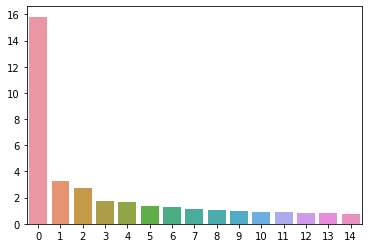

In [134]:
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [135]:
U, Sigma, V_T = randomized_svd(M = tfidf_train_df.to_numpy(), n_components=15,
                    n_iter= 200, random_state=12345, transpose=False)

U[0]

array([ 0.05582434, -0.00816845,  0.08059456,  0.0509067 , -0.02323414,
        0.03899051,  0.02803617, -0.05926767, -0.059888  , -0.01378355,
       -0.05209999,  0.0564951 ,  0.00065788, -0.05582718,  0.04305007])

In [136]:
print("U           - ",U.shape)
print("Sigma       - ",Sigma.shape)
print("V_transpose - ",V_T.shape)

U           -  (350, 15)
Sigma       -  (15,)
V_transpose -  (15, 35001)


In [139]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
skl_decomp_obj = TruncatedSVD(n_components=100, n_iter=100, random_state=42)

tfidf_lsa_data = skl_decomp_obj.fit_transform(tfidf_train_df)

In [146]:
logreg_lsa = LogisticRegression()
logreg     = LogisticRegression()
logreg_param_grid = [{'penalty':['l1', 'l2']},
                 {'tol':[0.0001, 0.0005, 0.001]}]
grid_lsa_log = GridSearchCV(estimator=logreg_lsa,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=-1)
grid_log = GridSearchCV(estimator=logreg,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=-1)
best_lsa_logreg = grid_lsa_log.fit(tfidf_lsa_data, y_train_brown).best_estimator_
best_reg_logreg = grid_log.fit(tfidf_train_df, y_train_brown).best_estimator_
print("Accuracy of Logistic Regression on LSA train data is :", best_lsa_logreg.score(tfidf_lsa_data, y_train_brown))

C:\Users\Esra\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.33714286 0.33714286 0.33714286 0.33714286]
  warnings.warn(
C:\Users\Esra\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.33142857 0.33142857 0.33142857 0.33142857]
  warnings.warn(


Accuracy of Logistic Regression on LSA train data is : 0.4057142857142857


C:\Users\Esra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


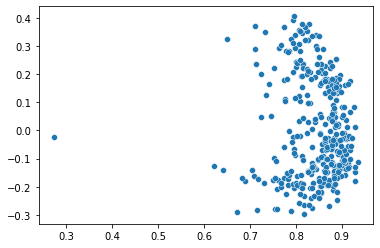

C:\Users\Esra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


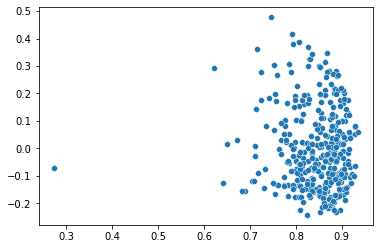

C:\Users\Esra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


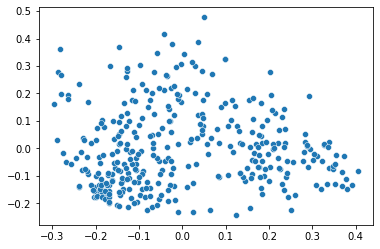

In [147]:
sns.scatterplot(tfidf_lsa_data[:,0], tfidf_lsa_data[:,1])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,0], tfidf_lsa_data[:,2])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,1], tfidf_lsa_data[:,2])
plt.show();